Model creation and evaluation

--Module and data imports

In [1]:
import import_data_module
import data_cleaner_module
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

data = import_data_module.import_dataframe_from_csv("../model_data/CrabAgePrediction.csv")
data_cleaned = data_cleaner_module.clean_Data(data)

data_cleaned.reset_index(drop=True, inplace=True)

Data standardization

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = data_cleaned.select_dtypes(include=['float', 'int']).columns

scaled_data = scaler.fit_transform(data_cleaned[cols_to_scale])

scaled_dataframe = pd.DataFrame(scaled_data, columns=cols_to_scale)

scaled_dataframe = pd.concat([scaled_dataframe, data_cleaned.drop(columns=cols_to_scale)], axis=1)


Data encoding

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

cols_to_encode = data_cleaned.select_dtypes(include=['object']).columns

encoded_data = label_encoder.fit_transform(data_cleaned[cols_to_encode[0]].values)

encoded_dataframe = pd.DataFrame(encoded_data, columns=cols_to_encode)

prepared_dataframe = pd.concat([encoded_dataframe, scaled_dataframe.drop(columns=cols_to_encode)], axis=1)

Data split and feauture select

In [4]:
print(prepared_dataframe.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')


In [88]:
feature = prepared_dataframe.drop(columns=['Age', 'Sex', 'Shell Weight', 'Viscera Weight'])
target = prepared_dataframe["Age"]

X_train, X_test, y_train, y_test =  train_test_split(feature, target, test_size=0.35, random_state=0)

Linear Regression

In [89]:
from sklearn.linear_model import Ridge

linear = Ridge(alpha=0.5)

linear.fit(X_train, y_train)

print("Intercept: ", linear.intercept_)
print("Coefficients: ", linear.coef_)

linear_predictions = linear.predict(X_test)

Intercept:  -0.012208477692060352
Coefficients:  [-0.16944284  0.44662288  0.29649367  1.4089592  -1.4339055 ]


Linear Evaluation

Mae: 0.49132411344545257
 Mse: 0.46241096000621973 
 RMSE: 0.6800080587803499 
 R2: 0.5366070003633203


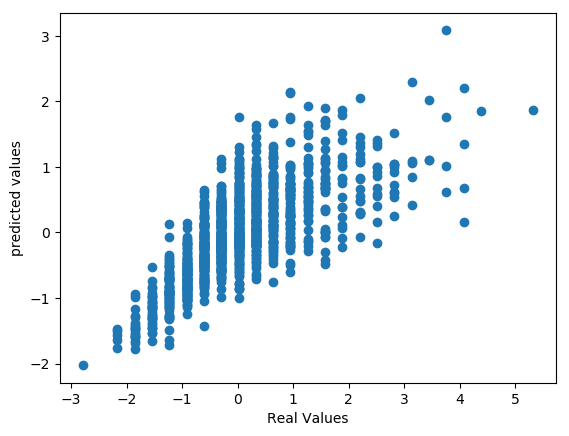

In [90]:
mae = mean_absolute_error(y_test, linear_predictions)
mse = mean_squared_error(y_test, linear_predictions)
r2 = r2_score(y_test, linear_predictions)

print(f"Mae: {mae}\n Mse: {mse} \n RMSE: {math.sqrt(mse)} \n R2: {r2}")

plt.scatter(y_test, linear_predictions)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.show()

Random forest

-- data selection

In [6]:
print(prepared_dataframe.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')


In [94]:
feature = prepared_dataframe.drop(columns=['Age', 'Viscera Weight'])
target = prepared_dataframe["Age"]

X_train, X_test, y_train, y_test =  train_test_split(feature, target, test_size=0.35, random_state=42)

--model

In [95]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=6, max_features=None, n_estimators=496)

rf_model.fit(X_train, y_train)

rf_predict = rf_model.predict(X_test)

Random forest evaluation

Mae: 0.4879321277761753
 Mse: 0.4722123650750751 
 RMSE: 0.6871770987708155 
 R2: 0.5299365712956243


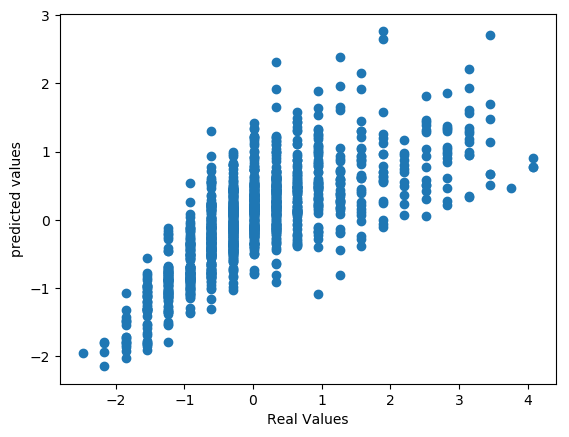

In [96]:
mae = mean_absolute_error(y_test, rf_predict)
mse = mean_squared_error(y_test, rf_predict)
r2 = r2_score(y_test, rf_predict)

print(f"Mae: {mae}\n Mse: {mse} \n RMSE: {math.sqrt(mse)} \n R2: {r2}")

plt.scatter(y_test, rf_predict)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.show()

Random forest cross validation

In [98]:
from sklearn.model_selection import cross_val_score

rf_scores = cross_val_score(rf_model, feature, target, cv=5)

print(f"Scores: {rf_scores}\n Mean: {rf_scores.mean()}\n Devation: {rf_scores.std()}")

Scores: [0.51284583 0.55809698 0.48403531 0.50051841 0.59794794]
 Mean: 0.5306888937777797
 Devation: 0.04166574691682859


Random forest hyperparameters random search

In [97]:
params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(2, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=8, cv=6, random_state=0, error_score='raise')

rf_search.fit(X_train, y_train)

print(f"Best params: {rf_search.best_estimator_}")

Best params: RandomForestRegressor(max_depth=6, max_features=None, n_estimators=496)
